In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 84.7 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np

np.random.seed(42)

In [3]:
n_wires = 4
graph = [(0, 1), (0, 3), (1, 2), (2, 3)]


# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        qml.CNOT(wires=edge)
        qml.RZ(gamma, wires=edge[1])
        qml.CNOT(wires=edge)
        # Could also do
        # IsingZZ(gamma, wires=edge)

In [4]:
def bitstring_to_int(bit_string_sample):
    return int(2 ** np.arange(len(bit_string_sample)) @ bit_string_sample[::-1])

In [5]:
dev = qml.device("lightning.qubit", wires=n_wires, shots=20)

In [6]:
@qml.qnode(dev)
def circuit(gammas, betas, return_samples=False):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for gamma, beta in zip(gammas, betas):
        U_C(gamma)
        U_B(beta)

    if return_samples:
        # sample bitstrings to obtain cuts
        return qml.sample()
    # during the optimization phase we are evaluating the objective using expval
    C = qml.sum(*(qml.Z(w1) @ qml.Z(w2) for w1, w2 in graph))
    return qml.expval(C)


def objective(params):
    """Minimize the negative of the objective function C by postprocessing the QNnode output."""
    return -0.5 * (len(graph) - circuit(*params))

In [7]:
def qaoa_maxcut(n_layers=1):
    print(f"\np={n_layers:d}")

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params.copy()
    steps = 30
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print(f"Objective after step {i+1:3d}: {-objective(params): .7f}")

    # sample 100 bitstrings by setting return_samples=True and the QNode shot count to 100
    bitstrings = circuit(*params, return_samples=True, shots=100)
    # convert the samples bitstrings to integers
    sampled_ints = [bitstring_to_int(string) for string in bitstrings]

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(sampled_ints))
    most_freq_bit_string = np.argmax(counts)
    print(f"Optimized parameter vectors:\ngamma: {params[0]}\nbeta:  {params[1]}")
    print(f"Most frequently sampled bit string is: {most_freq_bit_string:04b}")

    return -objective(params), sampled_ints


# perform QAOA on our graph with p=1,2 and keep the lists of sampled integers
int_samples1 = qaoa_maxcut(n_layers=1)[1]
int_samples2 = qaoa_maxcut(n_layers=2)[1]


p=1
Objective after step   5:  2.7000000
Objective after step  10:  2.6000000
Objective after step  15:  2.8000000
Objective after step  20:  3.1000000
Objective after step  25:  2.5000000
Objective after step  30:  2.8000000
Optimized parameter vectors:
gamma: [-0.85012621]
beta:  [-1.1387739]
Most frequently sampled bit string is: 0101

p=2
Objective after step   5:  3.9000000
Objective after step  10:  4.0000000
Objective after step  15:  4.0000000
Objective after step  20:  3.7000000
Objective after step  25:  4.0000000
Objective after step  30:  4.0000000
Optimized parameter vectors:
gamma: [-0.87006543 -1.12209739]
beta:  [0.60119142 0.4741234 ]
Most frequently sampled bit string is: 1010


In [8]:
def qaoa_maxcut(n_layers=1):
    print(f"\np={n_layers:d}")

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params.copy()
    steps = 30
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print(f"Objective after step {i+1:3d}: {-objective(params): .7f}")

    # sample 100 bitstrings by setting return_samples=True and the QNode shot count to 100
    bitstrings = circuit(*params, return_samples=True, shots=100)
    # convert the samples bitstrings to integers
    sampled_ints = [bitstring_to_int(string) for string in bitstrings]

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(sampled_ints))
    most_freq_bit_string = np.argmax(counts)
    print(f"Optimized parameter vectors:\ngamma: {params[0]}\nbeta:  {params[1]}")
    print(f"Most frequently sampled bit string is: {most_freq_bit_string:04b}")

    return -objective(params), sampled_ints


# perform QAOA on our graph with p=1,2 and keep the lists of sampled integers
int_samples1 = qaoa_maxcut(n_layers=1)[1]
int_samples2 = qaoa_maxcut(n_layers=2)[1]


p=1
Objective after step   5:  2.5000000
Objective after step  10:  3.1000000
Objective after step  15:  2.7000000
Objective after step  20:  3.0000000
Objective after step  25:  2.9000000
Objective after step  30:  2.6000000
Optimized parameter vectors:
gamma: [-0.68652458]
beta:  [0.3008973]
Most frequently sampled bit string is: 1010

p=2
Objective after step   5:  1.8000000
Objective after step  10:  3.4000000
Objective after step  15:  3.6000000
Objective after step  20:  4.0000000
Objective after step  25:  4.0000000
Objective after step  30:  4.0000000
Optimized parameter vectors:
gamma: [0.90178055 1.06578107]
beta:  [-0.52024997 -0.46475929]
Most frequently sampled bit string is: 1010


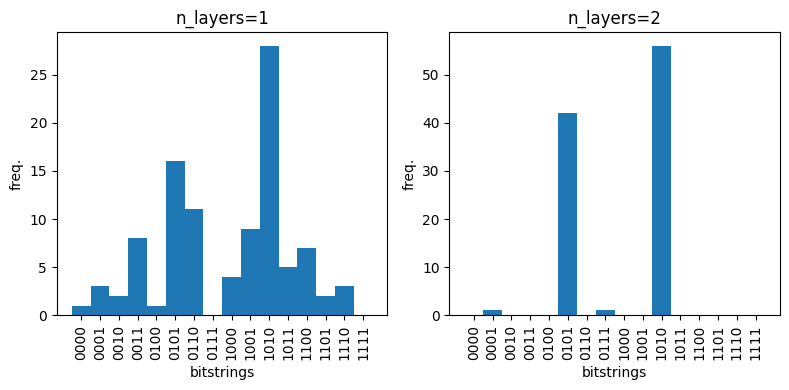

In [9]:
import matplotlib.pyplot as plt

xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, _ = plt.subplots(1, 2, figsize=(8, 4))
for i, samples in enumerate([int_samples1, int_samples2], start=1):
    plt.subplot(1, 2, i)
    plt.title(f"n_layers={i}")
    plt.xlabel("bitstrings")
    plt.ylabel("freq.")
    plt.xticks(xticks, xtick_labels, rotation="vertical")
    plt.hist(samples, bins=bins)
plt.tight_layout()
plt.show()